# Assignment 2: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture on K-means or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_2_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment.

In [1]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import pandas as pd
from sklearn.compose import ColumnTransformer


pd.set_option('display.max_column', None)

# Your code goes here for this section.

In [2]:
def load_test_data():
    return pd.read_csv("data/housing.csv")

In [3]:
df = load_test_data()

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
numerical_features = df.select_dtypes(include=['int','float']).columns
categorical_features = df.select_dtypes(include=['object']).columns

In [6]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

In [7]:
def full_pipeline(data, numerical_pipeline, numerical_columns, categorical_pipeline, categorical_features):
    df_clean_numerical = numerical_pipeline.fit_transform(data[numerical_features])
    df_clean_categorical = categorical_pipeline.fit_transform(data[categorical_features])
    
    df_clean_categorical = pd.DataFrame(df_clean_categorical.toarray(), columns=categorical_pipeline.get_feature_names_out(categorical_features))
    df_clean_numerical = pd.DataFrame(df_clean_numerical, columns=numerical_features)
    
    df_clean = pd.concat([df_clean_numerical, df_clean_categorical], axis=1)

    return df_clean

In [8]:
df_cleaned = full_pipeline(df, numerical_pipeline, numerical_features, categorical_pipeline, categorical_features)

In [9]:
df_cleaned.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.327835,1.052548,0.982143,-0.804819,-0.975228,-0.974429,-0.977033,2.344766,2.129631,0.0,0.0,0.0,1.0,0.0
1,-1.322844,1.043185,-0.607019,2.045890,1.355088,0.861439,1.669961,2.332238,1.314156,0.0,0.0,0.0,1.0,0.0
2,-1.332827,1.038503,1.856182,-0.535746,-0.829732,-0.820777,-0.843637,1.782699,1.258693,0.0,0.0,0.0,1.0,0.0
3,-1.337818,1.038503,1.856182,-0.624215,-0.722399,-0.766028,-0.733781,0.932968,1.165100,0.0,0.0,0.0,1.0,0.0
4,-1.337818,1.038503,1.856182,-0.462404,-0.615066,-0.759847,-0.629157,-0.012881,1.172900,0.0,0.0,0.0,1.0,0.0


- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [14]:
import random
import numpy as np

In [29]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).


def KMeans(data, K, distance_measure, num_iterations):
    centroids = initialize_random_centroids(data,K)

    for iteration in range(num_iterations):

        cluster_assignments = assign_to_centroids(data, centroids, distance_measure)

        new_centroids = calculate_centroids(data, cluster_assignments, K)

        #check for convergence
        if np.array_equal(centroids, new_centroids):
            break

        centroids = new_centroids

    return cluster_assignments, centroids
        
    

# returns a random sample of k elements from the original data.
def initialize_random_centroids(data, K):
    return random.sample(data.values.tolist(), K)

def assign_to_centroids(data, centroids, distance_measure):
    cluster_assignments = []

    for _, row in data.iterrows():
        distances = []
        data_point = row.values.astype(float)
        
        for centroid in centroids:
            if distance_measure==1:
                distance = np.sum(np.abs(data_point - centroid))
            elif distance_measure==2:
                distance = np.sqrt(np.sum((data_point-centroid) ** 2))
            elif distance_measure>=2:
                distance = np.max(np.abs(data_point-centroid))
            else:
                print("Invalid distance_measure: ", distance_measure)

            distances.append(distance)

        assigned_cluster = np.argmin(distances)
        cluster_assignments.append(assigned_cluster)


    return cluster_assignments


def calculate_centroids(data, cluster_assignments, K):

    new_centroids = np.zeros((K, data.shape[1]))

    for cluster in range(K):
        cluster_points = data[np.array(cluster_assignments) == cluster]

        if len(cluster_points) > 0:
            new_centroid = np.mean(cluster_points, axis=0)
            new_centroids[cluster] = new_centroid

    return new_centroids


def calculate_sse(data, centroids, cluster_assignments):
    sse = 0
    for i, centroid in enumerate(centroids):
        cluster_points = data[np.array(cluster_assignments) == i]
        if len(cluster_points) > 0:
            squared_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
            sse += np.sum(squared_distances)
    return sse
    

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


In [30]:
cluster_assignments1, centroids1 = KMeans(df_cleaned, 2, 2, 100)

In [164]:
cluster_assignments1, centroids1 = KMeans(df_cleaned, 2, 2, 100)
cluster_assignments2, centroids2 = KMeans(df_cleaned, 3, 2, 100)
cluster_assignments3, centroids3 = KMeans(df_cleaned, 4, 2, 100)
cluster_assignments4, centroids4 = KMeans(df_cleaned, 10, 2, 100)

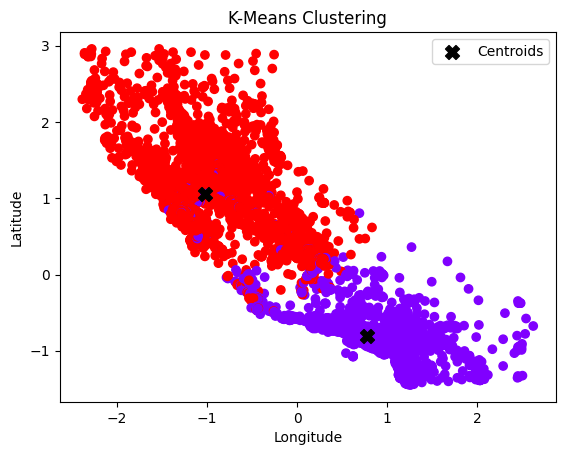

SSE:  162061.45562032575
Cluster Means:
 0.4318798449612403 

Cluster STD's:
 0.49534990928953054 



In [174]:
# Your code goes here
import matplotlib.pyplot as plt

# Create a scatter plot of the data points colored by cluster assignment.

def plot_clustering(df_cleaned, centroids, cluster_assignments):
    plt.scatter(df_cleaned['longitude'], df_cleaned['latitude'], c=cluster_assignments, cmap='rainbow')
    
    # Plot centroids as markers.
    plt.scatter(centroids[:,0], centroids[: ,1], marker='X', s=100, c='black', label='Centroids')
    
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('K-Means Clustering')
    plt.legend()
    plt.show()

    #print the sqrt(SSE)
    print("SSE: ", (calculate_sse(df_cleaned, centroids, cluster_assignments)))
    df_grouped = df_cleaned.copy()
    df_grouped['Clusters'] = cluster_assignments
    #df_grouped.groupby("Clusters")
    print(f"Cluster Means:\n {df_grouped['Clusters'].mean()} \n")
    print(f"Cluster STD's:\n {df_grouped['Clusters'].std()} \n")


# Your paragraph goes here for this section
'''
When using K=2 for our KMeans clustering algorithm, depending on the random value provided by the random library in python, we often get a pretty clean split across the state of California
bisecting the state into two clean halves. Another common outcome is the clustering algorithm getting lost in the median_house_value and instead clustering east-west with houses closer
to the coast being in one cluster and those more inland being in another. This problem can often be entirely mitigated by using K=3 which allows for both clusterings to be true, coastal homes
being in their own cluster and then north-south being clusters. The K=2 approach essentially split the state into NorCal and SoCal likely based mostly on the longitude and latitude variables.
If we instead base our clustering exclusively on median_house_value we will get a more east-west split. 
'''
plot_clustering(df_cleaned, centroids1, cluster_assignments1)

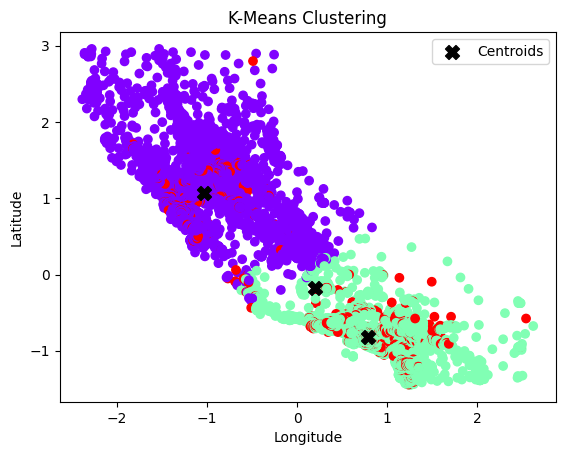

SSE:  122225.25360408153
Cluster Means:
 0.6771802325581395 

Cluster STD's:
 0.6190779569767609 



In [175]:
plot_clustering(df_cleaned, centroids2, cluster_assignments2)

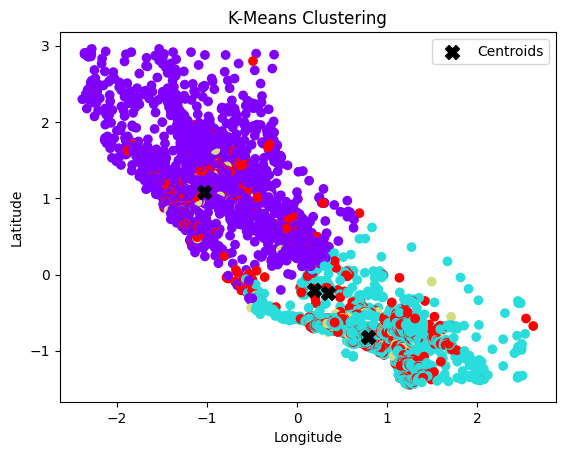

SSE:  109376.68071087837
Cluster Means:
 0.9157461240310077 

Cluster STD's:
 0.9768997801062413 



In [176]:
plot_clustering(df_cleaned, centroids3, cluster_assignments3)

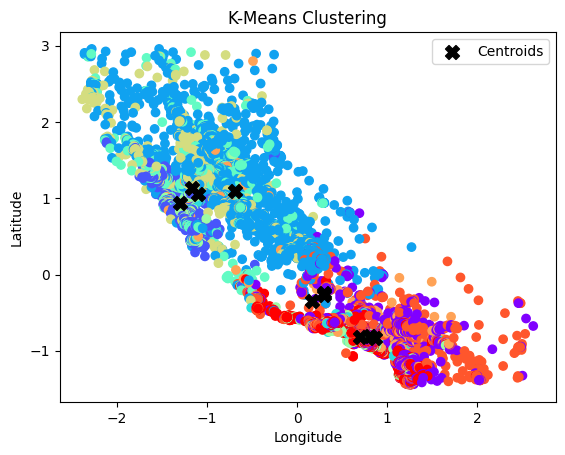

SSE:  69452.48248230158
Cluster Means:
 4.865455426356589 

Cluster STD's:
 3.2751419895993865 



In [177]:
plot_clustering(df_cleaned, centroids4, cluster_assignments4)
'''
Potential for Silicon Valley / San Franciso split here, clustering certainly gets intense in that area. Other patterns certainly include the north/south split but the remainder
of the clusters somewhat overlap causing some chaos especially in the south near San Diego.
'''

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge.



In [ ]:
'''
After experimenting with my KMeans implementation and overlapping the centroids and the actual map of California I was able to arrive at a few possible conclusions. It currently seems
thet there are a few solid lines we can draw to cluster our data. The NorCal/SoCal split is evident in all clusters > 1 and a Coastal/Inland split can also be seen in almost all 
examples provided. Past that, when scaling up K we begin to see very specific splitting that likely occurs because of very particular housing prices in highly desirable areas. Silicon Valley
and San Francisco for instance clearly results in some chaos around those centroids likely due to the above mentioned house values. Past these clear separators it becomes more difficult to
confidently lock down what is causing the centroids to settle where they do. It is clear that having a K of 10 is extreme and results in evidently overlapping centroids, so I would
expect a K around 4-5 to give us the best splitting. From here I would likely continue to experiment with different K's, different iteration counts, different random_states for np.random
and more close inspection of the map to try and find more granular conclusion opportunities. 
'''

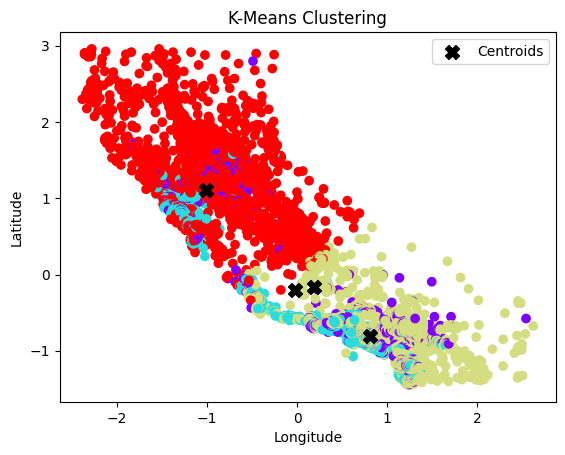

SSE:  107066.88933978727
Cluster Means:
 2.051841085271318 

Cluster STD's:
 0.8926738562501024 



'\nHere is close to what I would say is a reasonable clustering, coasts get there clusters as well as an obvious east-west split. Arround this K seems ideal. \n'

In [180]:
cluster_assignments, centroids = KMeans(df_cleaned, 4, 2, 100)
plot_clustering(df_cleaned, centroids, cluster_assignments)
'''
Here is close to what I would say is a reasonable clustering, coasts get there clusters as well as an obvious east-west split. Arround this K seems ideal. 
'''

- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 2:...".

Best of luck and have fun!